In [1]:
# Define a class to receive the characteristics of each line detection
from collections import deque
class Line():
    def __init__(self,window_size):
        self.detected = deque(maxlen=window_size)    # was the line detected in the last iteration?
        self.right_fit = deque(maxlen=window_size) # [np.array([False])]  # polynomial coefficients for the most recent fit
        self.left_fit = deque(maxlen=window_size) # np.array([0,0,0], dtype='float') # difference in fit coefficients between last and new fits        
        self.left_radius = deque(maxlen=window_size)         # radius of curvature of the line in some units
        self.right_radius = deque(maxlen=window_size)         # radius of curvature of the line in some units
        self.line_base_pos = deque(maxlen=window_size)               # distance in meters of vehicle center from the line
        self.left_window_x = deque(maxlen=window_size)
        self.right_window_x = deque(maxlen=window_size)    

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
cal_imgs = ['camera_cal/calibration%d.jpg'%(x) for x in range(1,21)]
straight_imgs = ['test_images/straight_lines%d.jpg'%(x) for x in [1,2]]
test_imgs = ['test_images/test%d.jpg'%(x) for x in range(1,7)]
all_imgs = straight_imgs+test_imgs
nx,ny=9,6
image_shape = (1280, 720) #gray.shape[::-1]
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
line_history = Line(30)


def get_chessboard_corners(fname):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        return corners
    else:
        return None    
    
def calibrate_camera(fnames):
    imgpoints = []
    objpoints_chessboard = np.stack(np.meshgrid(range(9),range(6),range(1)), axis=-1).reshape(-1,3).astype(np.float32)
    objpoints = []
    for fname in fnames:
        new_imgpoints = get_chessboard_corners(fname)
        if new_imgpoints is not None:
            imgpoints.append(new_imgpoints)
            objpoints.append(objpoints_chessboard)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    return ret,mtx,dist,rvecs,tvecs

def get_perspective_trf():
    src = np.asarray([[295,660],[1023,660],[766,500],[518,500]],dtype=np.float32)
    dst = np.asarray([[295,660],[1023,660],[1023,500],[295,500]],dtype=np.float32)
    #src = np.asarray([[209,720],[1091,720],[666,439],[613,439]],dtype=np.float32)
    #dst = np.asarray([[409,720],[891,720],[891,0],[409,0]],dtype=np.float32)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    return M,Minv

def undistort(img,mtx,dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
        

def genvideo(input_video_file,output_video_file,frame_trf):
    test_clip = VideoFileClip(input_video_file)
    new_clip = test_clip.fl_image(frame_trf) #NOTE: this function expects color images!!
    new_clip.write_videofile(output_video_file, audio=False)
    
def showvideo(vfile):    
    vtemplate="""<video width="640" height="300" controls><source src="{0}" type="video/mp4"></video>"""
    return HTML(vtemplate.format(vfile))

def threshold_img(val,thrs):
    ret = np.zeros_like(val)
    ret[(val>thrs[0]) & (val<=thrs[1])]=1
    return ret

def calc_lane_base(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base,rightx_base


def binary_image(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    s_binary = threshold_img(hls[:,:,2],(90, 255))
    sxbinary = threshold_img(scaled_sobelx,(20,255))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #combined_binary[sxbinary == 1] = 1
    return combined_binary,s_binary,sxbinary

def draw_windows(img,windows):
    for (xlow,ylow,xhigh,yhigh) in windows: 
        cv2.rectangle(img,(xlow,ylow),(xhigh,yhigh),(0,255,0),2)
    return img

def get_potential_lane_pixels_by_windowing(combined_binary):
    leftx_base,rightx_base = calc_lane_base(combined_binary)
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    nwindows = 9
    window_height = np.int(combined_binary.shape[0]/nwindows)
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []  
    # Step through the windows one by one
    right_windows = []
    left_windows = []
    left_window_x = [leftx_current]
    right_window_x = [rightx_current]
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = combined_binary.shape[0] - (window+1)*window_height
        win_y_high = combined_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        left_windows = left_windows + [(win_xleft_low,win_y_low,win_xleft_high,win_y_high)]
        right_windows = right_windows + [(win_xright_low,win_y_low,win_xright_high,win_y_high)]
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        elif window > 3:
            leftx_current = 3*(left_window_x[-1]-left_window_x[-2])+left_window_x[-3]
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        elif window > 3:
            rightx_current = 3*(right_window_x[-1]-right_window_x[-2])+right_window_x[-3]
        left_window_x = left_window_x + [leftx_current]
        right_window_x = right_window_x + [rightx_current]
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    return leftx,lefty,rightx,righty,left_windows,right_windows,left_window_x,right_window_x

def get_points_from_windows(combined_binary_image,window_xs,window_height,margin,nwindows):
    nzy,nzx = combined_binary_image.nonzero()
    ymax = combined_binary_image.shape[0]
    inds = []
    for win_id,wx in zip(range(nwindows),window_xs):
        yl = ymax-(win_id+1)*window_height
        yh = ymax-win_id*window_height
        xl = wx - margin
        xh = wx + margin
        good_inds = ((nzy>=yl) & (nzy<yh) & (nzx>=xl) & (nzx<xh)).nonzero()[0]
        inds.append(good_inds)
    inds = np.concatenate(inds)
    return nzx[inds],nzy[inds]

def radius_of_curvature(xpts,ypts):
    fit_cr = np.polyfit(ypts*ym_per_pix,xpts*xm_per_pix,2)
    y_eval=720
    return ((1+(2*fit_cr[0]*y_eval*ym_per_pix+fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])

def find_lanes(undist_img,M,Minv,hist):
    rgb = cv2.warpPerspective(undist_img, M, image_shape, flags=cv2.INTER_LINEAR)
    combined_binary,_,_ = binary_image(rgb)
    leftx,lefty,rightx,righty,left_windows,right_windows,left_window_x,right_window_x = get_potential_lane_pixels_by_windowing(combined_binary)
    left_fit,right_fit,left_fitx,right_fitx,ploty = fitted_line(leftx,lefty,rightx,righty,undist_img.shape[0])
    final_image,offset = draw_lane_region(undist_img,leftx,lefty,rightx,righty,Minv,right_fitx,left_fitx,ploty)
    left_curverad = radius_of_curvature(leftx,lefty)
    right_curverad = radius_of_curvature(rightx,righty)
    final_image = show_text(final_image,left_curverad,right_curverad,offset)
    return final_image
    
    
def show_text(img,left_cr,right_cr,offset):
    font = cv2.FONT_HERSHEY_SIMPLEX
    txt = 'radii '+str(int(left_cr))+' '+str(int(right_cr))+' offset '+str(offset)
    img = cv2.putText(img, txt, (230, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    return img

def show_thresholded_images(rgb,sbin,sxbin,combined):
    f, ((p1,p2),(p3,p4)) = plt.subplots(2,2, figsize=(20,10))
    p1.set_title('hist')
    p1.plot(hist(combined))
    p2.set_title('sbin')
    p2.imshow(sbin,cmap='gray')
    p3.set_title('sxbin')
    p3.imshow(sxbin,cmap='gray')
    p4.set_title('combined')
    p4.imshow(combined, cmap='gray')
    
def visualize_lanes(warped_orig,binary_img,final_image,left_fit,right_fit,nonzerox,nonzeroy,left_lane_inds,right_lane_inds,left_radius,right_radius,offset):
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    binary_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    binary_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    f,(origplt,processed,final_output) = plt.subplots(1,3)
    origplt.imshow(warped_orig)
    processed.imshow(binary_img)
    processed.plot(left_fitx, ploty, color='yellow')
    processed.plot(right_fitx, ploty, color='yellow')
    final_output.imshow(final_image)
    final_output.text(5,5,'radius'+str(int(left_radius))+' '+str(int(right_radius))+' offset '+str(offset),fontsize=12)

def get_ypoints(num_ypoints):
    return np.linspace(0, num_ypoints-1, num_ypoints )

def get_xpoints(fit,ploty):
    return fit[0]*ploty**2 + fit[1]*ploty + fit[2]

def get_points(left_fit,right_fit,num_ypoints):
    ploty = get_ypoints(num_ypoints)
    left_fitx = get_xpoints(left_fit,ploty)
    right_fitx = get_xpoints(right_fit,ploty)
    return left_fitx,right_fitx,ploty
    
def fitted_line(leftx,lefty,rightx,righty,num_ypoints):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fitx,right_fitx,ploty = get_points(left_fit,right_fit,num_ypoints)
    return left_fit,right_fit,left_fitx,right_fitx,ploty

def draw_lane_lines(img,leftx,lefty,rightx,righty,left_fitx,right_fitx,ploty):
    left_pts = np.array([[y,x] for x,y in zip(ploty,left_fitx)],np.int32)
    right_pts = np.array([[q,p] for p,q in zip(ploty,right_fitx)],np.int32)
    cv2.polylines(img,[left_pts,right_pts],False,(255,0,0))
    return img

def draw_lane_region(undist,leftx,lefty,rightx,righty,Minv,left_fitx,right_fitx,ploty):
    color_warp = np.zeros_like(undist)
    lane_center = (left_fitx[-1]+right_fitx[-1])*0.5
    car_center = (undist.shape[1]*0.5)
    offset = np.absolute(lane_center-car_center)*xm_per_pix
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result,offset

def lane_lines(img,mtx,dist,M,Minv):
    img_undistorted = undistort(img,mtx,dist)
    img_undistorted_unwarped = cv2.warpPerspective(img_undistorted,M,img_shape)
    img_binary = binary_image(img_undistorted_unwarped)
    leftx,lefty,rightx,righty,left_windows,right_windows = get_potential_lane_pixels_by_windowing(img_binary)
    left_fit,right_fit,left_fitx,right_fitx,ploty = fitted_line(leftx,lefty,rightx,righty)
    out_img = np.dstack([img_binary]*3)*255
    out_img = draw_windows(out_img,left_windows+right_windows)
    return draw_lane_lines(out_img,leftx,lefty,rightx,righty)

def histogram_image(img,mtx,dist,M,Minv):
    img_undistorted = undistort(img,mtx,dist)
    img_undistorted_unwarped = cv2.warpPerspective(img_undistorted,M,image_shape)
    img_binary,_,_ = binary_image(img_undistorted_unwarped)
    out_img = np.dstack([img_binary]*3)*255
    histogram = np.sum(img_binary[img.shape[0]//2:,:], axis=0)
    pts = list(zip(range(10000),720-histogram))
    cv2.polylines(img,[np.array(pts,np.int32)],False,(255,0,0))
    return img

def unwarped_image_with_windows(img,mtx,dist,M,Minv):
    img_undistorted  = undistort(img,mtx,dist)
    img_undistorted_unwarped = cv2.warpPerspective(img_undistorted,M,img_shape)
    img_binary = binary_image(img_undistorted_unwarped)
    leftx,lefty,rightx,righty,left_windows,right_windows = get_potential_lane_pixels_by_windowing(img_binary)
    draw_windows(img_undistorted_unwarped,left_windows+right_windows)
    return img_undistorted_unwarped

def concat_images(images):
    num_images_per_row = int(np.sqrt(len(images)))
    if len(images)>num_images_per_row*num_images_per_row:
        num_images_per_row +=1
    num_rows = int(len(images)/num_images_per_row)
    if len(images)>num_rows*num_images_per_row:
        num_rows+=1
    num_blank_images = num_images_per_row *num_rows - len(images)
    images += [np.zeros_like(images[0])]*num_blank_images
    return np.vstack([np.hstack(images[i*num_images_per_row:(i+1)*num_images_per_row]) for i in range(num_rows)])

def combined_trfs(img,f1,f2,f3,f4):
    img1 = f1(img)
    img2 = f2(img)
    img3 = f3(img)
    img4 = f4(img)
    return np.concatenate((np.concatenate((img1,img2),axis=0),np.concatenate((img3,img4),axis=0)),axis=1)

def combined_video(img,mtx,dist,M,Minv,hist):
    avg = lambda x : sum(x)/len(x)
    img_undistorted = undistort(img,mtx,dist)
    img_undistorted_unwarped = cv2.warpPerspective(img_undistorted,M,img_shape)
    img_binary,s_binary,sx_binary = binary_image(img_undistorted_unwarped)
    leftx,lefty,rightx,righty,left_windows,right_windows,left_window_x,right_window_x = get_potential_lane_pixels_by_windowing(img_binary)
    line_history.left_window_x.append(np.array(left_window_x))
    line_history.right_window_x.append(np.array(right_window_x))
    left_window_x = avg(line_history.left_window_x)
    right_window_x = avg(line_history.right_window_x)
    leftx,lefty=get_points_from_windows(combined_binary_image=img_binary,margin=100,nwindows=9,window_height=img.shape[0]/9,
                            window_xs=left_window_x)
    rightx,righty=get_points_from_windows(combined_binary_image=img_binary,margin=100,nwindows=9,window_height=img.shape[0]/9,
                            window_xs=right_window_x)
    histogram = np.sum(img_binary[img.shape[0]//2:,:], axis=0)
    pts = list(zip(range(10000),720-histogram))
    s_binary = np.dstack([s_binary]*3)*255
    sx_binary = np.dstack([sx_binary]*3)*255
    out_img = np.dstack([img_binary]*3)*255
    cv2.polylines(out_img,[np.array(pts,np.int32)],False,(255,0,0))
    original_image_with_windows = draw_windows(np.copy(img_undistorted_unwarped),left_windows+right_windows)
    binary_image_with_windows = draw_windows(out_img,left_windows+right_windows)
    left_fit,right_fit,left_fitx,right_fitx,ploty = fitted_line(leftx,lefty,rightx,righty,img.shape[0])
    hist.right_fit.append(right_fit)
    hist.left_fit.append(left_fit)
    left_fit = avg(hist.left_fit)
    right_fit = avg(hist.right_fit)
    left_fitx,right_fitx,ploty = get_points(left_fit=left_fit,right_fit=right_fit,num_ypoints=img.shape[0])
    binary_image_with_windows = draw_lane_lines(binary_image_with_windows,leftx,lefty,rightx,righty,left_fitx,right_fitx,ploty)
    final_image,offset = draw_lane_region(img_undistorted,leftx,lefty,rightx,righty,Minv,left_fitx,right_fitx,ploty)
    left_curverad = radius_of_curvature(leftx,lefty)
    right_curverad = radius_of_curvature(rightx,righty)
    hist.left_radius.append(left_curverad)
    hist.right_radius.append(right_curverad)
    hist.line_base_pos.append(offset)
    #hist.update(detected,left_fit,right_fit,left_curverad,right_curverad,offset,left_window_x,right_window_x)
    final_image = show_text(final_image,avg(hist.left_radius),avg(hist.right_radius),avg(hist.line_base_pos))
    return concat_images([img,original_image_with_windows,binary_image_with_windows,final_image])
    

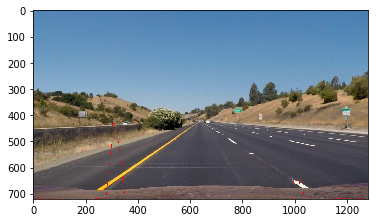

In [3]:
ret,mtx,dist,rvecs,tvecs = calibrate_camera(cal_imgs)
M,Minv = get_perspective_trf()
imgs = [mpimg.imread(x) for x in all_imgs]
undistorted_imgs = [undistort(img,mtx,dist) for img in imgs]
plt.imshow(histogram_image(imgs[0],mtx,dist,M,Minv))

In [4]:
distorted_chessboard_fname='./camera_cal/calibration1.jpg'	
undistorted_chessboard_fname='./myoutput/undistorted_chessboard.jpg'
distorted_lane_test_fname='./test_images/test1.jpg' 
distorted_straight_lane_fname='./test_images/straight_lines1.jpg'
undistorted_lane_test_fname='./myoutput/undistorted_lane_test.jpg' 
unwarped_undistorted_lane_test_fname='./myoutput/unwarped_undistorted_lane_test.jpg'	
unwarped_undistorted_straight_lane_fname='./myoutput/unwarped_undistorted_straight_lane.jpg'
binary_image_fname='./myoutput/binary_image.jpg' 
color_image_with_fitted_line_fname ='./myoutput/color_image_with_fitted_line.jpg'
lane_region_fname='./myoutput/lane_region_marked.jpg'
output_video_fname='myoutput/project_video_with_lane_region.mp4'
input_video_fname='./project_video.mp4'
input_challenge_video_fname='./challenge_video.mp4'
output_challenge_video_fname='myoutput/challenge_video_with_lane_region.mp4'
input_harder_challenge_video_fname='./harder_challenge_video.mp4'
output_harder_challenge_video_fname = 'myoutput/harder_challenge_video_with_lane_region.mp4'

cv2.imwrite(undistorted_chessboard_fname,undistort(cv2.imread(distorted_chessboard_fname),mtx,dist))
undistorted_lane_test_img = undistort(cv2.imread(distorted_lane_test_fname),mtx,dist)
cv2.imwrite(undistorted_lane_test_fname,undistorted_lane_test_img)
undistorted_straight_lane_img = undistort(cv2.imread(distorted_straight_lane_fname),mtx,dist)
img_shape = undistorted_lane_test_img.shape[1],undistorted_lane_test_img.shape[0]
unwarped_undistorted_lane_test_img = cv2.warpPerspective(undistorted_lane_test_img,M,img_shape)
unwarped_undistorted_straight_lane_img = cv2.warpPerspective(undistorted_straight_lane_img,M,img_shape)
cv2.imwrite(unwarped_undistorted_lane_test_fname,unwarped_undistorted_lane_test_img)
cv2.imwrite(unwarped_undistorted_straight_lane_fname,unwarped_undistorted_straight_lane_img)
binary_lane_img,_,_ = binary_image(unwarped_undistorted_lane_test_img)
leftx,lefty,rightx,righty,left_windows,right_windows,left_window_x,right_window_x = get_potential_lane_pixels_by_windowing(binary_lane_img)
#line_history.left_window_x.append(left_window_x)
#line_history.right_window_x.append(right_window_x)
left_fit,right_fit,left_fitx,right_fitx,ploty = fitted_line(leftx,lefty,rightx,righty,binary_lane_img.shape[0])
out_img = np.dstack((binary_lane_img,binary_lane_img,binary_lane_img))*255
out_img = draw_windows(out_img,left_windows+right_windows)
out_img = draw_lane_lines(out_img,leftx,lefty,rightx,righty,left_fitx,right_fitx,ploty)
cv2.imwrite(binary_image_fname,out_img)
lane_region = find_lanes(undistorted_lane_test_img,M,Minv,Line(0))
cv2.imwrite(lane_region_fname,lane_region)

for (in_video,out_video) in [(input_video_fname,output_video_fname),
                             (input_challenge_video_fname,output_challenge_video_fname),
                             (input_harder_challenge_video_fname,output_harder_challenge_video_fname)][:1]:
    f1 = lambda x:unwarped_image_with_windows(x,mtx,dist,M,img_shape)
    f2 = lambda x:histogram_image(x,mtx,dist,M,Minv)
    f3 = lambda x:lane_lines(x,mtx,dist,M,Minv)
    f4 = lambda x:find_lanes(undistort(x,mtx,dist),M,Minv)
    genvideo(in_video,'combined_efficient_'+out_video,lambda x: combined_video(x,mtx,dist,M,Minv,line_history))
    #genvideo(in_video,'combined_'+out_video,lambda x : combined_trfs(x,f1,f2,f3,f4))
    #genvideo(in_video,'unwarped_'+out_video,f1)
    #genvideo(in_video,'hist_'+out_video,f2)
    #genvideo(in_video,'lane_lines_'+out_video,f3))
    #genvideo(in_video,out_video,f4)
    

[MoviePy] >>>> Building video combined_efficient_myoutput/project_video_with_lane_region.mp4
[MoviePy] Writing video combined_efficient_myoutput/project_video_with_lane_region.mp4


100%|█████████▉| 1260/1261 [04:31<00:00,  4.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: combined_efficient_myoutput/project_video_with_lane_region.mp4 



In [5]:
lanes = [find_lanes(x,M,Minv) for x in undistorted_imgs]
for x in lanes:
    plt.figure()
    plt.imshow(x)
help(plt.imshow)

TypeError: find_lanes() missing 1 required positional argument: 'hist'

In [ ]:
genvideo('project_video.mp4','output_project_video.mp4',lambda x:find_lanes(x,M,Minv))
showvideo('output_project_video.mp4')


In [ ]:
pts = [np.array([[x,y] for x,y in zip(range(0,500,100),range(1,501,100))]),np.array([[0,512],[100,400],[200,300],[300,200],[400,100],[512,0]])]
img = np.zeros((512,512,3),np.uint8)
#img = np.zeros((512,512,3), np.uint8)
ret = cv2.polylines(img,pts,False,(255,255,255))
cv2.imwrite("out.jpg",img)
print(type(ret))
print(ret.shape)
plt.imshow(img)


In [ ]:
A = np.asarray(range(100))
A = A.reshape((10,10))
nz = A.nonzero()
nzx=np.array(nz[0])
nzy=np.array(nz[1])
print(nzx)
print(nzy)
((nzx>=5) & (nzx<8) & (nzy>=5) & (nzy<8)).nonzero()[0]
[[x,y] for x,y in zip(range(0,500,100),range(1,501,100))]

In [ ]:
x = 'abc' "def"
x

In [ ]:
a,b=np.asarray([1,2,3]),np.asarray([4,5,6])
np.vstack((a,b))

In [ ]:
help(np.stack)

In [ ]:
np.zeros(shape=(3,2),dtype=np.int32)